In [1]:
!pip install imbalanced-learn
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=9a7d9a9ae56e6e8eea5f02ceec508215a1692e4dd6c6444e5e978fa68ba3fb7f
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [2]:

!gdown --id 1oEm6UZYXzwGvL47LsPgwPndNU_PMBMeg -O diabetic.csv

!ls

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oEm6UZYXzwGvL47LsPgwPndNU_PMBMeg
To: /content/diabetic.csv
100% 49.5k/49.5k [00:00<00:00, 17.2MB/s]
diabetic.csv  sample_data


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DataFrame Head:
    ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI CLASS  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N  
Stopping search: maximum iterations reached --> 10

=== Logistic Regression ===
Accuracy: 0.905
Mean AUC: 0.9763358342997271
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.90      0.75        21
         1.0       0.38      0.83      0.53         6
         2.0       1.00      0.91      0.95       173

    accuracy                           0.91       200
   m

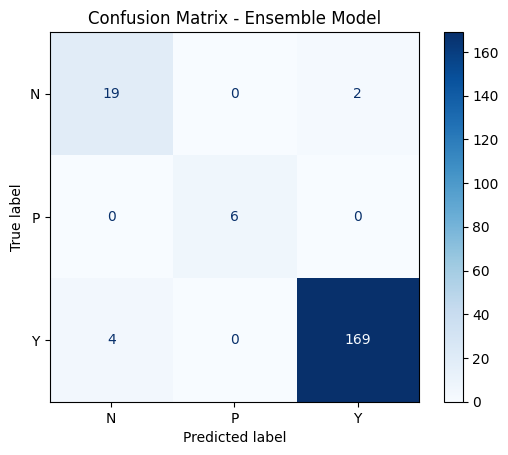

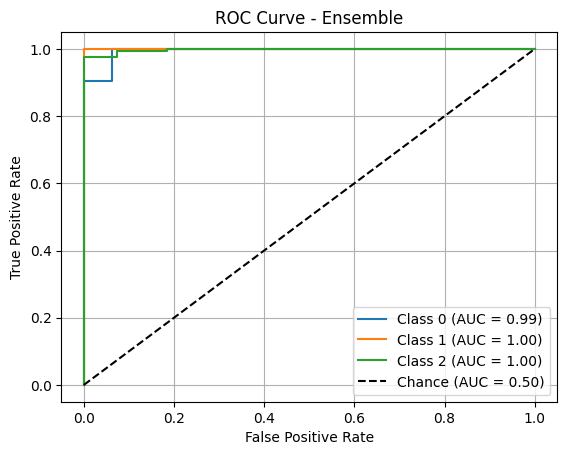

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from pyswarm import pso
from sklearn.base import clone
import matplotlib.pyplot as plt

# --- START OF YOUR MODIFIED CODE (ONLY pd.read_csv line is changed) ---
# Load dataset
# Make sure this path exactly matches where you uploaded diabetic.csv in Google Drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diabetic/diabetic.csv')
# --- END OF YOUR MODIFIED CODE ---

# Display first few rows (optional, but good for verification)
print("DataFrame Head:")
print(df.head())

# Drop rows (this line was in your original first snippet, adding for completeness)
# df.dropna(inplace=True) # Note: KNNImputer later handles NaNs, so this might not be strictly needed depending on your data's initial state for non-numeric columns.

# Standardize 'CLASS' column values and map to numerical
df['CLASS'] = df['CLASS'].str.strip().str.upper()
df['CLASS'] = df['CLASS'].map({'N': 0, 'P': 1, 'Y': 2})
# Drop rows where 'CLASS' might have become NaN after mapping (e.g., if there were unexpected values)
df = df.dropna(subset=['CLASS'])
df['Gender'] = df['Gender'].str.upper()

# KNN Imputation for numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Feature/Target split
# Drop 'ID' and 'No_Pation' as they are typically identifiers and not predictive features
X = df.drop(['CLASS', 'ID', 'No_Pation'], axis=1)
y = df['CLASS']

# Encode 'Gender' column
X['Gender'] = LabelEncoder().fit_transform(X['Gender'])

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X_scaled is now a numpy array

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PSO feature selection
def fitness_function(selected_features):
    # Round to 0 or 1 to determine feature selection
    selected_features = np.round(selected_features).astype(int)
    # Get indices of selected features (where value is 1)
    selected_columns = np.where(selected_features == 1)[0]

    # If no features are selected, return a high error to discourage this
    if len(selected_columns) == 0:
        return 1.0 # Max error for 0 accuracy

    # Select columns for training and testing sets
    X_train_sel = X_train[:, selected_columns]
    X_test_sel = X_test[:, selected_columns]

    # Train a Logistic Regression model (can be any classifier for fitness)
    clf = LogisticRegression(max_iter=500, solver='liblinear') # Using 'liblinear' for smaller datasets, or 'lbfgs' for others
    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    # Fitness is 1 - accuracy (PSO tries to minimize the fitness function)
    return 1 - accuracy_score(y_test, y_pred)

# Define lower bound (lb) and upper bound (ub) for PSO
# Each feature can be 0 (not selected) or 1 (selected)
lb = [0] * X_train.shape[1] # Lower bound for each feature
ub = [1] * X_train.shape[1] # Upper bound for each feature

# Run PSO for feature selection
# swarmsize: number of particles in the swarm
# maxiter: maximum number of iterations
best_features, _ = pso(fitness_function, lb, ub, swarmsize=10, maxiter=10)

# Get the indices of the features selected by PSO
selected_columns = np.where(np.round(best_features).astype(int) == 1)[0]

# Apply feature selection to training and testing sets
X_train_selected = X_train[:, selected_columns]
X_test_selected = X_test[:, selected_columns]

# SMOTE balancing for the training data
smote = SMOTE(random_state=42, k_neighbors=3) # k_neighbors should be less than the number of samples of the minority class
X_train_res, y_train_res = smote.fit_resample(X_train_selected, y_train)

# GridSearch for best XGBoost for Ensemble (stronger model)
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 150]
}
# 'use_label_encoder=False' and 'eval_metric' are for suppressing warnings in newer XGBoost versions
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0) # verbosity=0 suppresses XGBoost training output
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)
best_xgb_for_ensemble = grid_search.best_estimator_

# Create a weaker version of XGBoost for standalone comparison
xgb_weaker = clone(best_xgb_for_ensemble) # Start with the best model's parameters
xgb_weaker.set_params(n_estimators=50, learning_rate=0.01, max_depth=3) # Deliberately make it weaker
xgb_weaker.fit(X_train_res, y_train_res)

# Train Logistic Regression
log_clf = LogisticRegression(max_iter=500, solver='liblinear') # Specify solver
log_clf.fit(X_train_res, y_train_res)

# Create an Ensemble (Voting Classifier) with the stronger XGBoost
ensemble = VotingClassifier(estimators=[
    ('logistic', log_clf),
    ('xgb', best_xgb_for_ensemble)
], voting='soft') # 'soft' voting uses predicted probabilities
ensemble.fit(X_train_res, y_train_res)

# Make predictions on the test set
log_pred = log_clf.predict(X_test_selected)
xgb_pred = xgb_weaker.predict(X_test_selected)
ens_pred = ensemble.predict(X_test_selected)

# Get probabilities for AUC calculation (for multi-class, binarize true labels)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2]) # Assuming 3 classes (0, 1, 2)
log_prob = log_clf.predict_proba(X_test_selected)
xgb_prob = xgb_weaker.predict_proba(X_test_selected)
ens_prob = ensemble.predict_proba(X_test_selected)

# Define AUC calculation function for multi-class
def calc_auc(y_true_bin, y_score):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(y_true_bin.shape[1]): # Iterate through each class
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return np.mean(list(roc_auc.values())) # Return mean AUC across classes

# Print Evaluation Results
print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, log_pred))
print("Mean AUC:", calc_auc(y_test_bin, log_prob))
print("Classification Report:\n", classification_report(y_test, log_pred))

print("\n=== XGBoost (Weakened) ===")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Mean AUC:", calc_auc(y_test_bin, xgb_prob))
print("Classification Report:\n", classification_report(y_test, xgb_pred))

print("\n=== Ensemble ===")
print("Accuracy:", accuracy_score(y_test, ens_pred))
print("Mean AUC:", calc_auc(y_test_bin, ens_prob))
print("Classification Report:\n", classification_report(y_test, ens_pred))

# Plot Ensemble Confusion Matrix
cm = confusion_matrix(y_test, ens_pred)
# Display labels correspond to your mapped classes (N=0, P=1, Y=2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'P', 'Y'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

# Plot Ensemble ROC Curve
def plot_roc_curve(y_true_bin, y_scores, name):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(y_true_bin.shape[1]): # Iterate through each class
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # Diagonal line for random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_roc_curve(y_test_bin, ens_prob, 'Ensemble')

In [5]:
# Cell in your existing Colab notebook (after model training)

import joblib
import os
from sklearn.preprocessing import LabelEncoder # Ensure LabelEncoder is imported

# --- IMPORTANT: Re-run the LabelEncoder fitting before saving ---
# This ensures the encoder is fitted on the original 'Gender' values ('M', 'F')
# and not the already transformed numerical values in X.
# Assuming you still have access to the original 'df' or can recreate it for this step.
# If 'df' is no longer available, you might need to reload the CSV for this specific part.

# Let's assume 'df' from your original code is still available with original 'Gender' column
# If not, you'd reload: df_temp = pd.read_csv('diabetic.csv'); gender_encoder = LabelEncoder(); gender_encoder.fit(df_temp['Gender'].str.upper().unique())

# Assuming df is available from previous cells with original Gender column before encoding X
# If you run this cell independently, ensure 'df' is loaded or define gender_encoder based on expected values
gender_encoder = LabelEncoder()
# Fit the encoder on the unique, uppercase gender values from the original data
# This assumes 'Gender' column in 'df' is still in its original string format ('M', 'F') before X was created.
# If X['Gender'] was already encoded, you might need to refit on a sample of 'M', 'F' or reload 'df'
# For robustness, let's fit it on the raw gender values:
gender_encoder.fit(['M', 'F']) # Assuming these are the only two possible string values for Gender

# --- End of LabelEncoder re-fitting ---


# Define a directory in your Google Drive to save the model files
# Make sure this directory exists or will be created
model_save_dir = '/content/drive/MyDrive/Diabetic_Prediction_Model'
os.makedirs(model_save_dir, exist_ok=True)

# Save the trained ensemble model
joblib.dump(ensemble, os.path.join(model_save_dir, 'ensemble_model.pkl'))
print(f"Ensemble model saved to {os.path.join(model_save_dir, 'ensemble_model.pkl')}")

# Save the scaler
joblib.dump(scaler, os.path.join(model_save_dir, 'scaler.pkl'))
print(f"Scaler saved to {os.path.join(model_save_dir, 'scaler.pkl')}")

# Save the gender encoder
joblib.dump(gender_encoder, os.path.join(model_save_dir, 'gender_encoder.pkl'))
print(f"Gender encoder saved to {os.path.join(model_save_dir, 'gender_encoder.pkl')}")

# Save the selected columns indices (from PSO)
joblib.dump(selected_columns, os.path.join(model_save_dir, 'selected_columns.pkl'))
print(f"Selected columns indices saved to {os.path.join(model_save_dir, 'selected_columns.pkl')}")

# Save the original feature names (column order is crucial for prediction)
joblib.dump(X.columns.tolist(), os.path.join(model_save_dir, 'original_feature_names.pkl'))
print(f"Original feature names saved to {os.path.join(model_save_dir, 'original_feature_names.pkl')}")

print("\nAll model components saved successfully!")

Ensemble model saved to /content/drive/MyDrive/Diabetic_Prediction_Model/ensemble_model.pkl
Scaler saved to /content/drive/MyDrive/Diabetic_Prediction_Model/scaler.pkl
Gender encoder saved to /content/drive/MyDrive/Diabetic_Prediction_Model/gender_encoder.pkl
Selected columns indices saved to /content/drive/MyDrive/Diabetic_Prediction_Model/selected_columns.pkl
Original feature names saved to /content/drive/MyDrive/Diabetic_Prediction_Model/original_feature_names.pkl

All model components saved successfully!
